* [Andrej Karpathy: Building makemore Part 4: Becoming a Backprop Ninja](https://www.youtube.com/watch?v=q8SA3rM6ckI&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=6&ab_channel=AndrejKarpathy)

In [1]:
with open("../data/names.txt", "r") as f:
    words = f.read().splitlines()
print(words[:8])

chars = ["."] + sorted(list(set("".join(words))))
VOCAB_SIZE = len(chars)
print(f"{VOCAB_SIZE=}")

ctoi = {c:i for i,c in enumerate(chars)}
itoc = {i:c for c,i in ctoi.items()}

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
VOCAB_SIZE=27


In [2]:
import torch
import random

BLOCK_SIZE = 3
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [ctoi["."]] * BLOCK_SIZE
        for c in w + ".":
            X.append(context)
            idx = ctoi[c]
            Y.append(idx)
            context = context[1:] + [idx]


    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    print(X.shape, Y.shape)
    return X, Y

# Splits: train (0.8), val/dev (0.1), test (0.1).
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [3]:
g = torch.Generator().manual_seed(2147483647)

# Embedding.
EMB_DIM = 10
C = torch.randn((VOCAB_SIZE, EMB_DIM), generator=g)

# Layer 1.
HIDDEN_DIM = 64
W1_kaiming_std = (5/3) / ((BLOCK_SIZE * EMB_DIM) ** 0.5)
W1 = torch.randn((BLOCK_SIZE * EMB_DIM, HIDDEN_DIM), generator=g) * W1_kaiming_std
b1 = torch.randn(HIDDEN_DIM, generator=g) * 0.1  # For funzies. Does nothing b/c batch norm.

# Batch Norm.
bn_scale = torch.randn((1, HIDDEN_DIM), generator=g)*0.1 + 1.0
bn_bias = torch.randn((1, HIDDEN_DIM), generator=g)*0.1

# Layer 2.
W2 = torch.randn((HIDDEN_DIM, VOCAB_SIZE), generator=g) * 0.1
b2 = torch.randn(VOCAB_SIZE, generator=g) * 0.1

# NOTE: params aren't inited like normal b/c zero init can mask backprop problems.

parameters = [C, W1, b1, bn_scale, bn_bias, W2, b2]
for p in parameters:
    p.requires_grad = True

print(f"# params: {sum(p.numel() for p in parameters)}")

# params: 4137


In [4]:
# Create minibatch.
BATCH_SIZE = 32
inds = torch.randint(0, X_train.shape[0], (BATCH_SIZE,), generator=g)
xb, yb = X_train[inds], Y_train[inds]

In [5]:
# Forward.
# Embedding.
emb = C[xb]
concat_emb = emb.view(emb.shape[0], -1)

# Linear 1.
h_pre_bn = (concat_emb @ W1) + b1

# Batch norm.
bn_mean = (1.0 / BATCH_SIZE) * h_pre_bn.sum(dim=0, keepdim=True)
bn_diff = h_pre_bn - bn_mean

bn_diff2 = bn_diff ** 2.0
bn_var = (1.0 / (BATCH_SIZE - 1.0)) * bn_diff2.sum(dim=0, keepdim=True)  # Bessel's correction (1/n-1 vs. 1/n).
bn_std_inv = (bn_var + 1e-5) ** -0.5

bn_raw = bn_diff * bn_std_inv
h_preact = (bn_scale * bn_raw) + bn_bias

# Tanh.
h = h_preact.tanh()

# Linear 2.
logits = (h @ W2) + b2

# Cross entropy loss.
logit_maxes = logits.max(dim=-1, keepdim=True).values
norm_logits = logits - logit_maxes

counts = norm_logits.exp()
counts_sum = counts.sum(dim=-1, keepdim=True)
counts_sum_inv = counts_sum ** -1.0

probs = counts * counts_sum_inv

log_probs = probs.log()
loss = -log_probs[range(BATCH_SIZE), yb].mean()

# Backward.
for p in parameters:
    p.grad = None

for t in [
    log_probs, probs, counts_sum_inv, counts_sum, counts, norm_logits, logit_maxes, logits,
    h,
    h_preact, bn_raw, bn_std_inv, bn_var, bn_diff2, bn_diff, bn_mean,
    h_pre_bn,
    concat_emb, emb
]:
    t.retain_grad()

loss.backward()
loss

tensor(3.4586, grad_fn=<NegBackward0>)

In [6]:
@torch.no_grad()
def compare(x, y, name):
    assert x.shape == y.shape, f"Shapes don't match: {x.shape} and {y.shape}"
    exact = torch.all(x == y).item()
    allclose = torch.allclose(x, y)
    max_diff = (x - y).abs().max().item()
    print(f"{name:17s} exact: {str(exact):7s} allclose: {str(allclose):7s} max_diff: {max_diff}")

In [7]:
import torch.nn.functional as F

dlog_probs = torch.zeros_like(log_probs)
dlog_probs[range(BATCH_SIZE), yb] = -1.0 / BATCH_SIZE
compare(dlog_probs, log_probs.grad, "log_probs")

dprobs = (1.0 / probs) * dlog_probs
compare(dprobs, probs.grad, "probs")

dcounts = counts_sum_inv * dprobs

dcounts_sum_inv = (counts * dprobs).sum(dim=-1, keepdim=True)
compare(dcounts_sum_inv, counts_sum_inv.grad, "counts_sum_inv")

dcounts_sum = -(counts_sum ** -2.0) * dcounts_sum_inv
compare(dcounts_sum, counts_sum.grad, "counts_sum")

dcounts += torch.ones_like(counts) * dcounts_sum
compare(dcounts, counts.grad, "counts")

dnorm_logits = counts * dcounts
compare(dnorm_logits, norm_logits.grad, "norm_logits")

dlogits = dnorm_logits.clone()

dlogit_maxes = -dnorm_logits.sum(dim=-1, keepdim=True)
compare(dlogit_maxes, logit_maxes.grad, "logit_maxes")

dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
compare(dlogits, logits.grad, "logits")

dh = dlogits @ W2.T  # dh (32, 64) = dlogits (32, 27) @ W2.T (27, 64).
compare(dh, h.grad, "h")

dW2 = h.T @ dlogits
compare(dW2, W2.grad, "W2")

db2 = dlogits.sum(dim=0)
compare(db2, b2.grad, "b2")

dh_preact = (1.0 - (h ** 2.0)) * dh
compare(dh_preact, h_preact.grad, "h_preact")

dbn_scale = (bn_raw * dh_preact).sum(dim=0, keepdim=True)
compare(dbn_scale, bn_scale.grad, "bn_scale")

dbn_raw = bn_scale * dh_preact
compare(dbn_raw, bn_raw.grad, "bn_raw")

dbn_bias = dh_preact.sum(dim=0, keepdim=True)
compare(dbn_bias, bn_bias.grad, "bn_bias")

dbn_diff = bn_std_inv * dbn_raw

dbn_std_inv = (bn_diff * dbn_raw).sum(dim=0, keepdim=True)
compare(dbn_std_inv, bn_std_inv.grad, "bn_std_inv")

dbn_var = -0.5 * ((bn_var + 1e-5) ** -1.5) * dbn_std_inv
compare(dbn_var, bn_var.grad, "bn_var")

dbn_diff2 = (torch.ones_like(bn_diff2) / (BATCH_SIZE - 1.0)) * dbn_var
compare(dbn_diff2, bn_diff2.grad, "bn_diff2")

dbn_diff += (2.0 * bn_diff) * dbn_diff2
compare(dbn_diff, bn_diff.grad, "bn_diff")

dh_pre_bn = dbn_diff.clone()

dbn_mean = -dbn_diff.sum(dim=0, keepdim=True)
compare(dbn_mean, bn_mean.grad, "bn_mean")

dh_pre_bn += (torch.ones_like(h_pre_bn) / BATCH_SIZE) * dbn_mean
compare(dh_pre_bn, h_pre_bn.grad, "h_pre_bn")

dconcat_emb = dh_pre_bn @ W1.T
compare(dconcat_emb, concat_emb.grad, "concat_emb")

dW1 = concat_emb.T @ dh_pre_bn
compare(dW1, W1.grad, "W1")

db1 = dh_pre_bn.sum(dim=0)
compare(db1, b1.grad, "b1")

demb = dconcat_emb.view(emb.shape)
compare(demb, emb.grad, "emb")

dC = torch.zeros_like(C)
for x, g in zip(xb.view(-1), demb.view(-1, demb.shape[-1])):
    dC[x] += g
compare(dC, C.grad, "C")

log_probs         exact: True    allclose: True    max_diff: 0.0
probs             exact: True    allclose: True    max_diff: 0.0
counts_sum_inv    exact: True    allclose: True    max_diff: 0.0
counts_sum        exact: True    allclose: True    max_diff: 0.0
counts            exact: True    allclose: True    max_diff: 0.0
norm_logits       exact: True    allclose: True    max_diff: 0.0
logit_maxes       exact: True    allclose: True    max_diff: 0.0
logits            exact: True    allclose: True    max_diff: 0.0
h                 exact: True    allclose: True    max_diff: 0.0
W2                exact: True    allclose: True    max_diff: 0.0
b2                exact: True    allclose: True    max_diff: 0.0
h_preact          exact: False   allclose: True    max_diff: 9.313225746154785e-10
bn_scale          exact: False   allclose: True    max_diff: 1.862645149230957e-09
bn_raw            exact: False   allclose: True    max_diff: 9.313225746154785e-10
bn_bias           exact: False   all

In [8]:
import torch.nn.functional as F

# Fast all-in-one-go cross entropy forward.
loss_fast = F.cross_entropy(logits, yb)
compare(loss_fast, loss, "loss_fast")

# Fast all-in-one-go cross entropy backward.
dlogits_fast = F.softmax(logits, dim=-1)
dlogits_fast[torch.arange(dlogits_fast.shape[0]), yb] -= 1.0
dlogits_fast /= BATCH_SIZE
compare(dlogits_fast, logits.grad, "logits_fast")

loss_fast         exact: True    allclose: True    max_diff: 0.0
logits_fast       exact: False   allclose: True    max_diff: 7.2177499532699585e-09


In [9]:
# Fused batch norm forward.
bn_std = torch.sqrt(h_pre_bn.var(dim=0, keepdim=True) + 1e-5)
bn_raw = (h_pre_bn - h_pre_bn.mean(dim=0, keepdim=True)) / bn_std
h_preact_fast = (bn_raw * bn_scale) + bn_bias
compare(h_preact_fast, h_preact, "bn_out")

# Fused batch norm backward.
dbn_bias = dh_preact.sum(dim=0, keepdim=True)
compare(dbn_bias, bn_bias.grad, "bn_bias")

dbn_scale = (bn_raw * dh_preact).sum(dim=0, keepdim=True)
compare(dbn_scale, bn_scale.grad, "bn_scale")

dh_pre_bn = (bn_scale / bn_std) * (dh_preact - (dh_preact.sum(0, keepdim=True) / BATCH_SIZE) - ((bn_raw * (bn_raw * dh_preact).sum(0, keepdim=True)) / (BATCH_SIZE - 1)))
compare(dh_pre_bn, h_pre_bn.grad, "h_pre_bn")

bn_out            exact: False   allclose: True    max_diff: 4.76837158203125e-07
bn_bias           exact: False   allclose: True    max_diff: 3.725290298461914e-09
bn_scale          exact: False   allclose: True    max_diff: 2.7939677238464355e-09
h_pre_bn          exact: False   allclose: True    max_diff: 1.3969838619232178e-09


0 loss=3.45862 max_diff=1.4901161193847656e-08
10000 loss=2.07426 max_diff=1.4901161193847656e-08
20000 loss=2.21370 max_diff=1.862645149230957e-08
30000 loss=2.25239 max_diff=1.4901161193847656e-08
40000 loss=1.74124 max_diff=1.955777406692505e-08
49999 loss=2.23978 max_diff=2.2351741790771484e-08


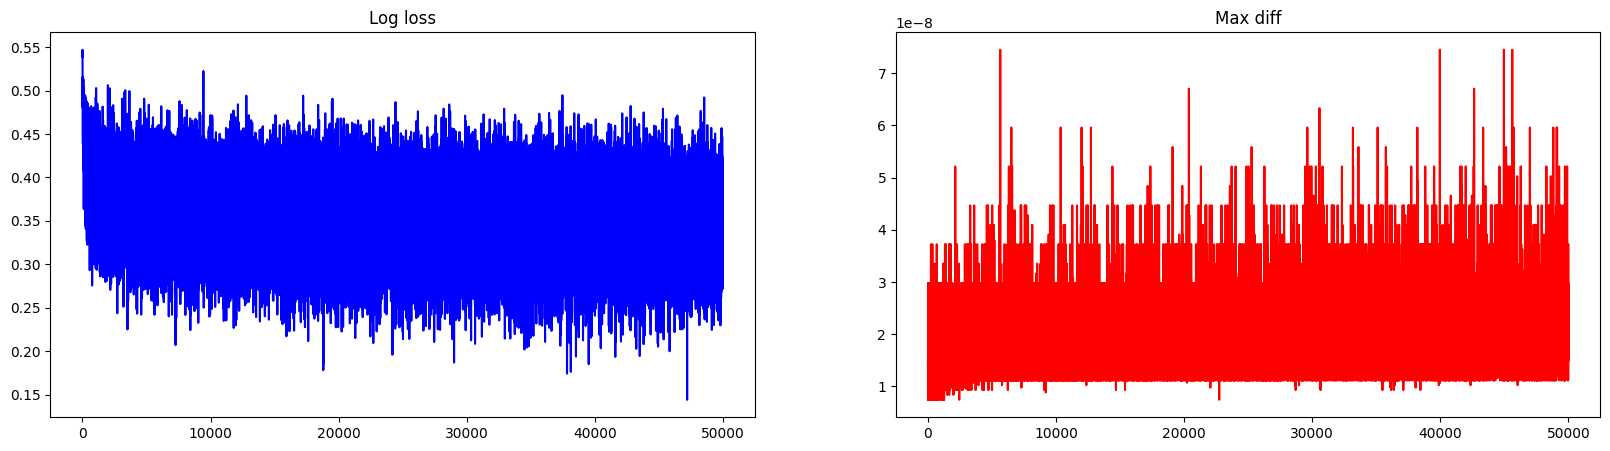

In [10]:
import matplotlib.pyplot as plt

# ----------Param init-----------.
g = torch.Generator().manual_seed(2147483647)

# Embedding.
EMB_DIM = 10
C = torch.randn((VOCAB_SIZE, EMB_DIM), generator=g)

# Layer 1.
HIDDEN_DIM = 64
W1_kaiming_std = (5/3) / ((BLOCK_SIZE * EMB_DIM) ** 0.5)
W1 = torch.randn((BLOCK_SIZE * EMB_DIM, HIDDEN_DIM), generator=g) * W1_kaiming_std
b1 = torch.randn(HIDDEN_DIM, generator=g) * 0.1  # For funzies. Does nothing b/c batch norm.

# Batch Norm.
bn_scale = torch.randn((1, HIDDEN_DIM), generator=g)*0.1 + 1.0
bn_bias = torch.randn((1, HIDDEN_DIM), generator=g)*0.1

# Layer 2.
W2 = torch.randn((HIDDEN_DIM, VOCAB_SIZE), generator=g) * 0.1
b2 = torch.randn(VOCAB_SIZE, generator=g) * 0.1

# NOTE: params aren't inited like normal b/c zero init can mask backprop problems.
parameters = (C, W1, b1, bn_scale, bn_bias, W2, b2)
for p in parameters:
    p.requires_grad = True

# ---------Train-----------.
BATCH_SIZE = 32
TRAIN_STEPS = 50_000

log_losses = []
max_diffs = []
for i in range(TRAIN_STEPS):
    # Create batch.
    inds = torch.randint(0, X_train.shape[0], (BATCH_SIZE,), generator=g)
    xb, yb = X_train[inds], Y_train[inds]

    # Forward.
    emb = C[xb]
    concat_emb = emb.view(emb.shape[0], -1)

    h_pre_bn = (concat_emb @ W1) + b1

    bn_std = torch.sqrt(h_pre_bn.var(dim=0, keepdim=True) + 1e-5)
    bn_raw = (h_pre_bn - h_pre_bn.mean(dim=0, keepdim=True)) / bn_std
    h_preact = (bn_raw * bn_scale) + bn_bias

    h = h_preact.tanh()

    logits = (h @ W2) + b2

    loss = F.cross_entropy(logits, yb)

    # Torch backward.
    for p in parameters:
        p.grad = None
    loss.backward()

    # Custom backward.
    with torch.no_grad():
        dlogits = F.softmax(logits, dim=-1)
        dlogits[torch.arange(dlogits.shape[0]), yb] -= 1.0
        dlogits /= BATCH_SIZE

        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(dim=0)
        dh_preact = (1.0 - (h ** 2.0)) * dh

        dbn_bias = dh_preact.sum(dim=0, keepdim=True)
        dbn_scale = (bn_raw * dh_preact).sum(dim=0, keepdim=True)
        dh_pre_bn = (bn_scale / bn_std) * (dh_preact - (dh_preact.sum(0, keepdim=True) / BATCH_SIZE) - ((bn_raw * (bn_raw * dh_preact).sum(0, keepdim=True)) / (BATCH_SIZE - 1)))

        dconcat_emb = dh_pre_bn @ W1.T
        dW1 = concat_emb.T @ dh_pre_bn
        db1 = dh_pre_bn.sum(dim=0)
        demb = dconcat_emb.view(emb.shape)
        dC = torch.zeros_like(C)
        for x, grad in zip(xb.view(-1), demb.view(-1, demb.shape[-1])):
            dC[x] += grad

        grads = (dC, dW1, db1, dbn_scale, dbn_bias, dW2, db2)
        names = ("C", "W1", "b1", "bn_scale", "bn_bias", "w2", "b2")

        # Track max diffs grads.
        max_diff = float("-inf")
        for grad, param in zip(grads, parameters):
            max_diff = max(max_diff, (grad - param.grad).abs().max().item())
        max_diffs.append(max_diff)

    # Optim.
    lr = 0.1 if i < 100_000 else 0.01
    for grad, param in zip(grads, parameters):
        param.data -= lr * grad

    # Track stats.
    if ((i % 10_000) == 0) or (i == (TRAIN_STEPS - 1)):
        print(f"{i} loss={loss.item():.5f} max_diff={max_diff}")
    log_losses.append(loss.log10().item())

# -------Plot loss and max diffs-------.
fig, (loss_ax, diff_ax) = plt.subplots(figsize=(20, 5), ncols=2)

loss_ax.plot(log_losses, c="blue")
loss_ax.set_title("Log loss")

diff_ax.plot(max_diffs, c="red")
diff_ax.set_title("Max diff");